In [4]:
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import matplotlib.pylab as plt

In [5]:
### 1.1) SBA_Loan dataset cleaning and transformation for creating a model:

In [6]:
SBA_Loan = pd.read_csv('SBA_Loan_test.csv')

In [7]:
DF_SBA_Loan = SBA_Loan.copy()
DF_SBA_Loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  int64  
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

In [8]:
DF_SBA_Loan.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
Industry                  0
dtype: int64

In [9]:
# Filling MIS_Status NaN values
for x in DF_SBA_Loan[DF_SBA_Loan['MIS_Status'].isnull()]['ChgOffPrinGr'].index:
    if DF_SBA_Loan['ChgOffPrinGr'][x] == 0:
        DF_SBA_Loan.loc[x,'MIS_Status'] = "P I F"
    else:
        DF_SBA_Loan.loc[x,'MIS_Status'] = "CHGOFF"

In [10]:
DF_SBA_Loan.drop(DF_SBA_Loan[DF_SBA_Loan["NAICS"] == 0].index, inplace=True) # Dropping NAICS = 0 for now

In [11]:
#Keeping just the first 2 digits in the NAICS column of DF_SBA_Loan
NAICS_value = [str(number) for number in np.array(DF_SBA_Loan["NAICS"])]
NAICS_first_two = [s[:2] for s in NAICS_value]
DF_SBA_Loan["NAICS"] = [int(x) for x in NAICS_first_two]

In [12]:
DF_SBA_Loan = DF_SBA_Loan[['State', 'NAICS', 'ApprovalFY', 'NewExist', 'MIS_Status', 'SBA_Appv', 'GrAppv']] #'UrbanRural', 'LowDoc' left out
DF_SBA_Loan = DF_SBA_Loan.reset_index(drop=True)
DF_SBA_Loan.drop(DF_SBA_Loan[DF_SBA_Loan['NewExist'] == 0].index, inplace=True)

In [13]:
DF_SBA_Loan = DF_SBA_Loan.dropna()

In [14]:
DF_SBA_Loan[{'MIS_Status',	'SBA_Appv', 'GrAppv'}]

,MIS_Status,SBA_Appv,GrAppv
0,P I F,48000.0,60000.0
1,P I F,32000.0,40000.0
2,P I F,215250.0,287000.0
3,P I F,387750.0,517000.0
4,P I F,36000.0,45000.0
...,...,...,...
697211,P I F,25000.0,50000.0
697212,P I F,150000.0,200000.0
697213,P I F,56000.0,70000.0
697214,P I F,42500.0,85000.0


In [15]:
# DF_SBA_Loan['UrbanRural'].value_counts()
# DF_SBA_Loan[DF_SBA_Loan['UrbanRural'] == 0]
# sns.countplot(x='NAICS', data=DF_SBA_Loan, hue='NewExist')
# DF_SBA_Loan['MIS_Status'].value_counts()

In [16]:
### 1.2) NAICS_BDS dataset cleaning and transformation for creating a new features for our model:

In [17]:
NAICS_BDS = pd.read_csv('NAICS_BDS_timeseries_data.csv', low_memory=False)
NAICS_BDS = NAICS_BDS.drop([0])
NAICS_BDS.head()

,GEO_ID,NAME,NAICS,NAICS_LABEL,YEAR,FIRM,ESTAB,EMP,DENOM,ESTABS_ENTRY,...,JOB_DESTRUCTION_DEATHS,JOB_DESTRUCTION_CONTINUERS,JOB_DESTRUCTION_RATE_DEATHS,JOB_DESTRUCTION_RATE,NET_JOB_CREATION,NET_JOB_CREATION_RATE,REALLOCATION_RATE,FIRMDEATH_FIRMS,FIRMDEATH_ESTABS,FIRMDEATH_EMP
1,0100000US,United States,0,Total for all sectors,1978,3557994,4310626,69410001,66810001,654226,...,4048046,5420961,6.059,14.173,5196537,7.778,28.346,327278,332504,1824251
2,0100000US,United States,0,Total for all sectors,1979,3692077,4472108,73848234,71727111,630253,...,3760616,6043218,5.243,13.668,4248257,5.923,27.336,328024,332633,1785478
3,0100000US,United States,0,Total for all sectors,1980,3739809,4533251,74109267,74018218,592484,...,4246135,7797198,5.737,16.271,188937,0.255,32.542,368578,373754,1941422
4,0100000US,United States,0,Total for all sectors,1981,3770852,4615479,75728652,74924061,606853,...,3478843,7782399,4.643,15.03,1609104,2.148,30.06,377291,383748,2005707
5,0100000US,United States,0,Total for all sectors,1982,3720273,4598769,74922226,75267274,572030,...,4055239,8683755,5.388,16.925,-678350,-0.901,32.048,412488,418501,2211944


In [18]:
DF_NAICS = NAICS_BDS.copy()
DF_NAICS.drop(DF_NAICS[(DF_NAICS.NAICS == '0')].index, inplace=True) #Dropping NAICS = 0 as it is the total for all the categories year wise

In [19]:
# Transforming NAICS range column to individual columns:
DF_NAICS.drop(DF_NAICS[(DF_NAICS.NAICS == '31-33') | (DF_NAICS.NAICS == '44-45') | (DF_NAICS.NAICS == '48-49')].index, inplace=True)
DF_NAICS = DF_NAICS.append([NAICS_BDS[NAICS_BDS["NAICS"] == '31-33']]*3, ignore_index=True)
DF_NAICS = DF_NAICS.append([NAICS_BDS[NAICS_BDS["NAICS"] == '44-45']]*2, ignore_index=True)
DF_NAICS = DF_NAICS.append([NAICS_BDS[NAICS_BDS["NAICS"] == '48-49']]*2, ignore_index=True)
# Renaming the NAICS entries of range-columns
temp_array = [31]*42 + [32]*42 + [33]*42
DF_NAICS = DF_NAICS.replace({'NAICS' : { '31-33' : temp_array}})
temp_array = [44]*42 + [45]*42
DF_NAICS = DF_NAICS.replace({'NAICS' : { '44-45' : temp_array}})
temp_array = [48]*42 + [49]*42
DF_NAICS = DF_NAICS.replace({'NAICS' : { '48-49' : temp_array}})

In [20]:
DF_NAICS.head()

,GEO_ID,NAME,NAICS,NAICS_LABEL,YEAR,FIRM,ESTAB,EMP,DENOM,ESTABS_ENTRY,...,JOB_DESTRUCTION_DEATHS,JOB_DESTRUCTION_CONTINUERS,JOB_DESTRUCTION_RATE_DEATHS,JOB_DESTRUCTION_RATE,NET_JOB_CREATION,NET_JOB_CREATION_RATE,REALLOCATION_RATE,FIRMDEATH_FIRMS,FIRMDEATH_ESTABS,FIRMDEATH_EMP
0,0100000US,United States,11,"Agriculture, forestry, fishing and hunting",1978,23763,24429,200156,192326,4717,...,18829,27500,9.79,24.089,15439,8.028,48.178,2876,2905,12497
1,0100000US,United States,11,"Agriculture, forestry, fishing and hunting",1979,21765,22373,192288,191325,4178,...,22142,30446,11.573,27.486,1716,0.897,54.972,3022,3068,14659
2,0100000US,United States,11,"Agriculture, forestry, fishing and hunting",1980,21882,22500,193997,193979,3827,...,16453,31944,8.482,24.95,-108,-0.056,49.788,2780,2780,11264
3,0100000US,United States,11,"Agriculture, forestry, fishing and hunting",1981,21862,22468,189977,193065,3514,...,20576,31625,10.658,27.038,-6316,-3.271,47.533,2696,2699,11719
4,0100000US,United States,11,"Agriculture, forestry, fishing and hunting",1982,19040,19695,173515,178279,2775,...,20541,31150,11.522,28.995,-9420,-5.284,47.421,3176,3180,14178


In [21]:
Keep_Columns_DF_NAICS = ['NAICS', 'YEAR', 'FIRM', 'DENOM', 'ESTABS_ENTRY', 'ESTABS_EXIT', 'JOB_CREATION', 'JOB_DESTRUCTION', 'REALLOCATION_RATE', 'FIRMDEATH_ESTABS', 'FIRMDEATH_EMP']
DF_NAICS = DF_NAICS[Keep_Columns_DF_NAICS]

In [22]:
To_int_Columns_DF_NAICS = ['NAICS', 'YEAR', 'FIRM', 'DENOM', 'ESTABS_ENTRY', 'ESTABS_EXIT', 'JOB_CREATION', 'JOB_DESTRUCTION', 'FIRMDEATH_ESTABS', 'FIRMDEATH_EMP']
for column_name in To_int_Columns_DF_NAICS:
    DF_NAICS[column_name] = [int(x) for x in DF_NAICS[column_name]]

DF_NAICS['REALLOCATION_RATE'] = [float(x) for x in DF_NAICS['REALLOCATION_RATE']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
### 1.3) Merging Dataset based on NAICS category and dates: Year from DF_NAICS and ApprovalFY from DF_SBA_Loan
DF_SBA_Loan = DF_SBA_Loan.rename(columns={"ApprovalFY": "YEAR"})
print(DF_SBA_Loan.shape)
print(DF_NAICS.shape)

(696342, 7)
(966, 11)


In [24]:
df_merged_NAICS_SBALoan = pd.merge(DF_SBA_Loan, DF_NAICS,  how='left', left_on=['NAICS','YEAR'], right_on = ['NAICS','YEAR'])
df_merged_NAICS_SBALoan = df_merged_NAICS_SBALoan.dropna()
df_merged_NAICS_SBALoan

,State,NAICS,YEAR,NewExist,MIS_Status,SBA_Appv,GrAppv,FIRM,DENOM,ESTABS_ENTRY,ESTABS_EXIT,JOB_CREATION,JOB_DESTRUCTION,REALLOCATION_RATE,FIRMDEATH_ESTABS,FIRMDEATH_EMP
0,IN,45,1997,2.0,P I F,48000.0,60000.0,670945.0,13763872.0,110091.0,115364.0,2361731.0,2038489.0,29.621,73384.0,349798.0
1,IN,72,1997,2.0,P I F,32000.0,40000.0,357519.0,9152783.0,69257.0,63282.0,1894562.0,1728105.0,37.761,45776.0,441164.0
2,IN,62,1997,1.0,P I F,215250.0,287000.0,481657.0,12684590.0,60737.0,50485.0,1943403.0,1632957.0,25.747,35763.0,328510.0
3,CT,33,1997,1.0,P I F,387750.0,517000.0,292577.0,16284152.0,28296.0,29516.0,1835979.0,1672272.0,20.539,22142.0,255029.0
4,FL,81,1997,2.0,P I F,36000.0,45000.0,599136.0,4864066.0,62099.0,58638.0,800963.0,694752.0,28.567,42290.0,156087.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696337,MD,33,1997,1.0,P I F,25000.0,50000.0,292577.0,16284152.0,28296.0,29516.0,1835979.0,1672272.0,20.539,22142.0,255029.0
696338,CA,31,1997,1.0,P I F,150000.0,200000.0,292577.0,16284152.0,28296.0,29516.0,1835979.0,1672272.0,20.539,22142.0,255029.0
696339,OH,45,1997,1.0,P I F,56000.0,70000.0,670945.0,13763872.0,110091.0,115364.0,2361731.0,2038489.0,29.621,73384.0,349798.0
696340,OH,45,1997,1.0,P I F,42500.0,85000.0,670945.0,13763872.0,110091.0,115364.0,2361731.0,2038489.0,29.621,73384.0,349798.0


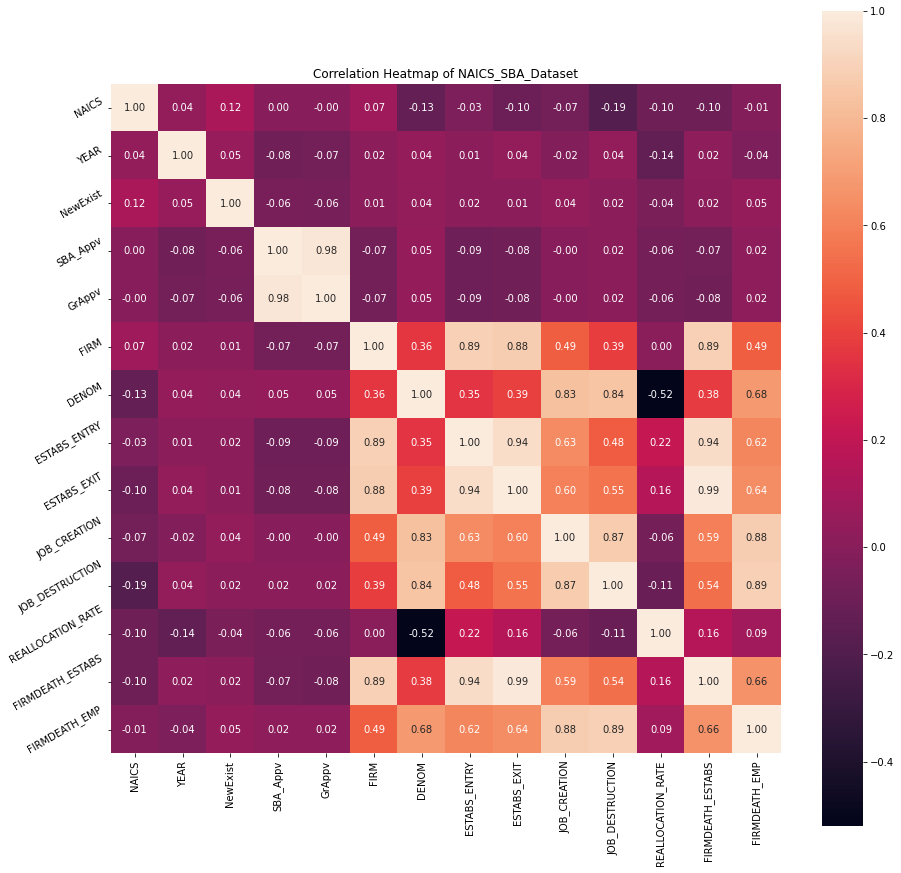

In [25]:
# Plotting correlation matrix
correlation = df_merged_NAICS_SBALoan.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Heatmap of NAICS_SBA_Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

In [26]:
### 1.4) Splitting the data into Train, Val and Test as per time-series:
df_merged_NAICS_SBALoan_train = df_merged_NAICS_SBALoan[df_merged_NAICS_SBALoan['YEAR']<=2007]
df_merged_NAICS_SBALoan_val = df_merged_NAICS_SBALoan[(df_merged_NAICS_SBALoan['YEAR'] == 2008) | (df_merged_NAICS_SBALoan['YEAR'] == 2009)]
df_merged_NAICS_SBALoan_test = df_merged_NAICS_SBALoan[df_merged_NAICS_SBALoan['YEAR'] >= 2010]

In [27]:
y_train = df_merged_NAICS_SBALoan_train['SBA_Appv'] / df_merged_NAICS_SBALoan_train['GrAppv']
X_train = df_merged_NAICS_SBALoan_train.drop(['SBA_Appv'], axis=1)
y_val = df_merged_NAICS_SBALoan_val['SBA_Appv'] / df_merged_NAICS_SBALoan_val['GrAppv']
X_val = df_merged_NAICS_SBALoan_val.drop(['SBA_Appv'], axis=1)
y_test = df_merged_NAICS_SBALoan_test['SBA_Appv'] / df_merged_NAICS_SBALoan_test['GrAppv']
X_test = df_merged_NAICS_SBALoan_test.drop(['SBA_Appv'], axis=1)

In [28]:
from sklearn.preprocessing import StandardScaler

# Define numerical features to use for modelling
num_features = ['GrAppv', 'FIRM', 'DENOM', 'ESTABS_ENTRY', 'ESTABS_EXIT', 'JOB_CREATION', 'JOB_DESTRUCTION', 'REALLOCATION_RATE', 'FIRMDEATH_ESTABS', 'FIRMDEATH_EMP']

# Define categorical features to use for modelling
cat_features = ['State', 'NAICS', 'MIS_Status']
misc_features = ['YEAR', 'NewExist']

# Fitting scaler for the training data
scaler = StandardScaler()
scaler.fit(X_train[num_features])

def features_scale_and_dummies(df):
    scaled = df[num_features].copy()
    # Convert numeric features to standard units
    scaled.iloc[:, :] = scaler.transform(scaled)
    # Convert categorical features using dummy encoding
    categoricals = [pd.get_dummies(df[s], prefix=s, drop_first=True) for s in cat_features]
    misc = df[misc_features]
    return pd.concat([scaled] + categoricals + [misc], axis=1)

In [29]:
X_train = features_scale_and_dummies(X_train)
X_val = features_scale_and_dummies(X_val)
X_test = features_scale_and_dummies(X_test)

In [30]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(599434, 85)
(58648, 85)
(38031, 85)


In [31]:
#Defining RMSE function
from sklearn import metrics
def rmse(y_pred, y):
    return np.sqrt(metrics.mean_squared_error(y_pred, y))
from sklearn.metrics import r2_score

In [32]:
### 1.4.1) Considering only Entering Entities features to train our model:
# Columns_to_keep = ['State', 'NAICS', 'YEAR', 'NewExist', 'MIS_Status', 'GrAppv', 'FIRM', 'DENOM', 'ESTABS_ENTRY', 'JOB_CREATION']
X_train_1 = X_train.drop(['ESTABS_EXIT', 'JOB_DESTRUCTION', 'REALLOCATION_RATE', 'FIRMDEATH_ESTABS', 'FIRMDEATH_EMP'], axis=1)
X_val_1 = X_val.drop(['ESTABS_EXIT', 'JOB_DESTRUCTION', 'REALLOCATION_RATE', 'FIRMDEATH_ESTABS', 'FIRMDEATH_EMP'], axis=1)

In [33]:
# Linear Regression - Performing Linear Regression
from sklearn.linear_model import LinearRegression
model_1 = LinearRegression(fit_intercept=True).fit(X_train_1, y_train)
y_train_predicted_1 = model_1.predict(X_train_1)
y_val_predicted_1 = model_1.predict(X_val_1)
# Linear Regression - RMSE for training and validation data
rmse_train_1 = rmse(y_train, y_train_predicted_1)
rmse_val_1 = rmse(y_val, y_val_predicted_1)
r2_train_1 = r2_score(y_train, y_train_predicted_1)
r2_val_1 = r2_score(y_val, y_val_predicted_1)
print("For the linear regression model in part 1:\n", "RMSE for training data is: ",rmse_train_1,"\n","RMSE for validation data is: ",rmse_val_1,"\n","R2 Score for training data is: ",r2_train_1,"\n","R2 Score for validation data is: ",r2_val_1)

For the linear regression model in part 1:
 RMSE for training data is:  0.13823452738522352 
 RMSE for validation data is:  0.18195496893333427 
 R2 Score for training data is:  0.36442538073122543 
 R2 Score for validation data is:  0.014596587208762335


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


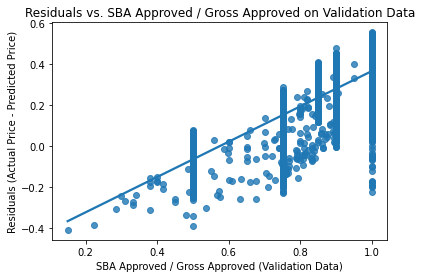

In [34]:
# Plotting residual Curves for the Regression model
residuals_1 = y_val - y_val_predicted_1
ax = sns.regplot(y_val, residuals_1)
ax.set_xlabel('SBA Approved / Gross Approved (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. SBA Approved / Gross Approved on Validation Data");

In [35]:
### 1.4.2) Considering only Exiting Entities features to train our model:
# Columns_to_keep = ['State', 'NAICS', 'YEAR', 'NewExist', 'MIS_Status', 'GrAppv', 'FIRM', 'DENOM', 'ESTABS_EXIT', 'JOB_DESTRUCTION', 'REALLOCATION_RATE', 'FIRMDEATH_ESTABS', 'FIRMDEATH_EMP']
X_train_2 = X_train.drop(['ESTABS_ENTRY', 'JOB_CREATION'], axis=1)
X_val_2 = X_val.drop(['ESTABS_ENTRY', 'JOB_CREATION'], axis=1)

In [36]:
# Linear Regression - Performing Linear Regression
model_2 = LinearRegression(fit_intercept=True).fit(X_train_2, y_train)
y_train_predicted_2 = model_2.predict(X_train_2)
y_val_predicted_2 = model_2.predict(X_val_2)
# Linear Regression - RMSE for training and validation data
rmse_train_2 = rmse(y_train, y_train_predicted_2)
rmse_val_2 = rmse(y_val, y_val_predicted_2)
r2_train_2 = r2_score(y_train, y_train_predicted_2)
r2_val_2 = r2_score(y_val, y_val_predicted_2)
print("For the linear regression model in part 2:\n", "RMSE for training data is: ",rmse_train_2,"\n","RMSE for validation data is: ",rmse_val_2,"\n","R2 Score for training data is: ",r2_train_2,"\n","R2 Score for validation data is: ",r2_val_2)

For the linear regression model in part 2:
 RMSE for training data is:  0.13815035384295604 
 RMSE for validation data is:  0.18300784141692863 
 R2 Score for training data is:  0.36519917118663237 
 R2 Score for validation data is:  0.0031596270073911414


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


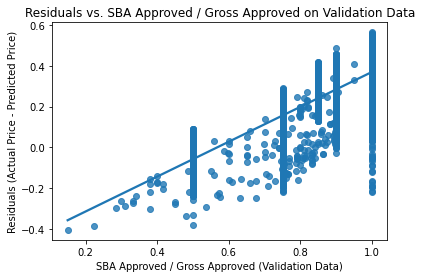

In [37]:
# Plotting residual Curves for the Regression model
residuals_2 = y_val - y_val_predicted_2
ax = sns.regplot(y_val, residuals_2)
ax.set_xlabel('SBA Approved / Gross Approved (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. SBA Approved / Gross Approved on Validation Data");

In [38]:
### 1.4.3) Considering all the features to train our model:
# Linear Regression - Performing Linear Regression
model_3 = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_train_predicted_3 = model_3.predict(X_train)
y_val_predicted_3 = model_3.predict(X_val)
# Linear Regression - RMSE for training and validation data
rmse_train_3 = rmse(y_train, y_train_predicted_3)
rmse_val_3 = rmse(y_val, y_val_predicted_3)
r2_train_3 = r2_score(y_train, y_train_predicted_3)
r2_val_3 = r2_score(y_val, y_val_predicted_3)
print("For the linear regression model in part 3:\n", "RMSE for training data is: ",rmse_train_3,"\n","RMSE for validation data is: ",rmse_val_3,"\n","R2 Score for training data is: ",r2_train_3,"\n","R2 Score for validation data is: ",r2_val_3)

For the linear regression model in part 3:
 RMSE for training data is:  0.13814835910286202 
 RMSE for validation data is:  0.18247831297607367 
 R2 Score for training data is:  0.3652175027143918 
 R2 Score for validation data is:  0.008919944779158584


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


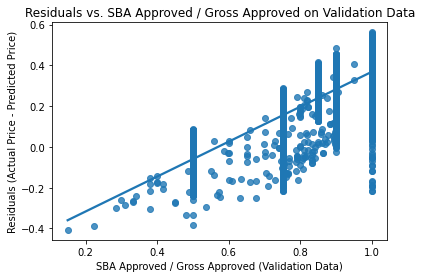

In [39]:
# Plotting residual Curves for the Regression model
residuals_3 = y_val - y_val_predicted_3
ax = sns.regplot(y_val, residuals_3)
ax.set_xlabel('SBA Approved / Gross Approved (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. SBA Approved / Gross Approved on Validation Data");

In [40]:
### Test data
y_test_predicted = model_3.predict(X_test)
# Linear Regression - RMSE for training and validation data
rmse_test = rmse(y_test, y_test_predicted)
r2_test = r2_score(y_test, y_test_predicted)
print("For the linear regression model in part 3:\n", "RMSE for test data is: ",rmse_test,"\n","R2 Score for test data is: ",r2_test)

For the linear regression model in part 3:
 RMSE for test data is:  0.20608466730021968 
 R2 Score for test data is:  -0.16253668221708817


In [41]:
### 1.5) Splitting the data into Train, Val and Test as per time-series:
df_merged_NAICS_SBALoan_train_val = df_merged_NAICS_SBALoan[df_merged_NAICS_SBALoan['YEAR']<=2009]
df_merged_NAICS_SBALoan_test = df_merged_NAICS_SBALoan[df_merged_NAICS_SBALoan['YEAR'] >= 2010]
y_train_val = df_merged_NAICS_SBALoan_train_val['SBA_Appv'] / df_merged_NAICS_SBALoan_train_val['GrAppv']
X_train_val = df_merged_NAICS_SBALoan_train_val.drop(['SBA_Appv'], axis=1)
y_test = df_merged_NAICS_SBALoan_test['SBA_Appv'] / df_merged_NAICS_SBALoan_test['GrAppv']
X_test = df_merged_NAICS_SBALoan_test.drop(['SBA_Appv'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state= 0)

In [42]:
# Fitting scaler for the new training data
scaler = StandardScaler()
scaler.fit(X_train[num_features])
# Redefining the function with new Scaler
def features_scale_and_dummies(df):
    scaled = df[num_features].copy()
    # Convert numeric features to standard units
    scaled.iloc[:, :] = scaler.transform(scaled)
    # Convert categorical features using dummy encoding
    categoricals = [pd.get_dummies(df[s], prefix=s, drop_first=True) for s in cat_features]
    misc = df[misc_features]
    return pd.concat([scaled] + categoricals + [misc], axis=1)

In [43]:
X_train = features_scale_and_dummies(X_train)
X_val = features_scale_and_dummies(X_val)
X_test = features_scale_and_dummies(X_test)

In [44]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(559369, 85)
(98713, 85)
(38031, 85)


In [45]:
# Linear Regression - Performing Linear Regression
model_3 = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_train_predicted_3 = model_3.predict(X_train)
y_val_predicted_3 = model_3.predict(X_val)
# Linear Regression - RMSE for training and validation data
rmse_train_3 = rmse(y_train, y_train_predicted_3)
rmse_val_3 = rmse(y_val, y_val_predicted_3)
r2_train_3 = r2_score(y_train, y_train_predicted_3)
r2_val_3 = r2_score(y_val, y_val_predicted_3)
print("For the linear regression model in part 3:\n", "RMSE for training data is: ",rmse_train_3,"\n","RMSE for validation data is: ",rmse_val_3,"\n","R2 Score for training data is: ",r2_train_3,"\n","R2 Score for validation data is: ",r2_val_3)

For the linear regression model in part 3:
 RMSE for training data is:  0.1416492717816312 
 RMSE for validation data is:  0.14192099845032857 
 R2 Score for training data is:  0.3417644626676698 
 R2 Score for validation data is:  0.3392913497046305


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


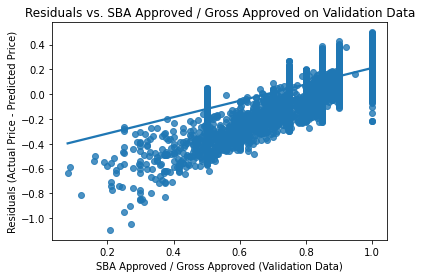

In [46]:
# Plotting residual Curves for the Regression model
residuals_3 = y_val - y_val_predicted_3
ax = sns.regplot(y_val, residuals_3)
ax.set_xlabel('SBA Approved / Gross Approved (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. SBA Approved / Gross Approved on Validation Data");

In [47]:
### Test data
y_test_predicted = model_3.predict(X_test)
# Linear Regression - RMSE for training and validation data
rmse_test = rmse(y_test, y_test_predicted)
r2_test = r2_score(y_test, y_test_predicted)
print("For the linear regression model in part 3:\n", "RMSE for test data is: ",rmse_test,"\n","R2 Score for test data is: ",r2_test)

For the linear regression model in part 3:
 RMSE for test data is:  0.19046700835605956 
 R2 Score for test data is:  0.006987253409693195


In [48]:
X_train

,GrAppv,FIRM,DENOM,ESTABS_ENTRY,ESTABS_EXIT,JOB_CREATION,JOB_DESTRUCTION,REALLOCATION_RATE,FIRMDEATH_ESTABS,FIRMDEATH_EMP,...,NAICS_55,NAICS_56,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,MIS_Status_P I F,YEAR,NewExist
595095,-0.285962,-1.730664,-1.301133,-1.315980,-1.428416,-1.381962,-1.602886,-0.691541,-1.378932,-1.496822,...,0,0,0,0,0,0,0,1,1995,1.0
593414,-0.118140,1.034884,1.256252,1.195971,1.284442,1.396366,0.748248,-0.810057,1.250270,0.772662,...,0,0,0,0,0,0,0,1,2004,1.0
407216,0.443699,-0.469191,0.148107,0.156103,-0.004674,0.823034,0.956943,1.297350,-0.052339,1.484184,...,0,0,0,0,0,1,0,1,2002,2.0
656600,-0.468378,0.484707,-0.930987,0.592091,0.427392,-0.384687,-0.512243,1.773361,0.655402,0.059069,...,0,0,0,0,0,0,0,1,1996,1.0
442790,-0.504861,-1.349752,-1.698165,-1.101091,-1.129525,-1.789802,-1.756098,1.767225,-1.092945,-1.550648,...,0,0,0,0,0,0,0,1,1993,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387445,1.830055,0.652795,-0.491372,0.754109,0.502425,0.153543,-0.216948,0.770760,0.522328,0.023214,...,0,0,0,0,0,0,0,1,2001,2.0
152396,-0.541344,-1.897395,-1.605346,-1.675131,-1.649194,-1.868862,-1.822936,-0.078757,-1.633217,-1.748244,...,0,0,0,0,1,0,0,0,2007,2.0
118021,-0.468378,1.023392,-0.369918,1.053312,0.767216,-0.077742,-0.081935,0.705666,0.742633,-0.066927,...,0,0,0,0,0,0,0,1,2007,1.0
472554,-0.109019,-0.058683,-0.993804,0.062544,-0.271519,-0.848925,-0.887666,0.801137,-0.150862,-0.856989,...,0,0,0,0,0,0,0,1,1993,1.0


**Feature Selection:**

In [49]:
df_merged_NAICS_SBALoan_train_val = df_merged_NAICS_SBALoan[df_merged_NAICS_SBALoan['YEAR']<=2009]
df_merged_NAICS_SBALoan_test = df_merged_NAICS_SBALoan[df_merged_NAICS_SBALoan['YEAR'] >= 2010]
y_train_val = df_merged_NAICS_SBALoan_train_val['SBA_Appv'] / df_merged_NAICS_SBALoan_train_val['GrAppv']
X_train_val = df_merged_NAICS_SBALoan_train_val.drop(['SBA_Appv'], axis=1)
y_test = df_merged_NAICS_SBALoan_test['SBA_Appv'] / df_merged_NAICS_SBALoan_test['GrAppv']
X_test = df_merged_NAICS_SBALoan_test.drop(['SBA_Appv'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state= 0)

In [50]:
X_train = features_scale_and_dummies(X_train)
X_val = features_scale_and_dummies(X_val)
X_test = features_scale_and_dummies(X_test)

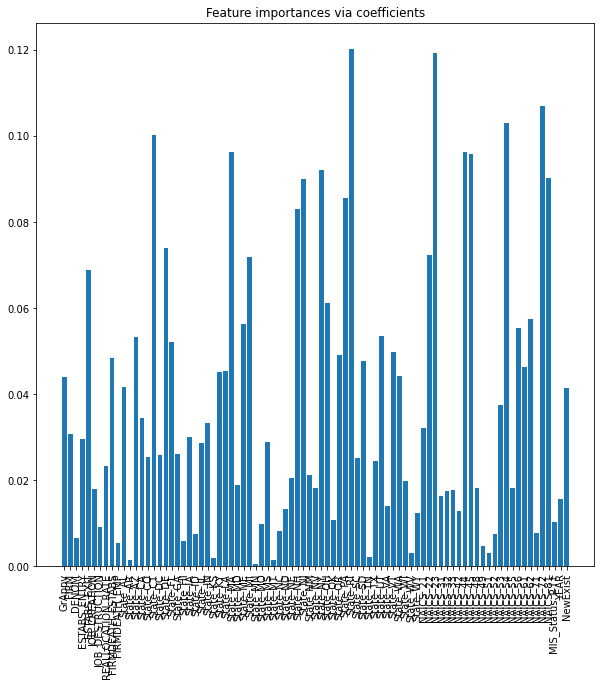

In [51]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
feature_names = X_train.columns
plt.figure(figsize=(10,10))
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

In [52]:
from sklearn.feature_selection import SelectFromModel
from time import time
threshold = np.sort(importance)[-10]
tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X_train, y_train)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: Index(['State_CT', 'State_MA', 'State_NY', 'State_RI', 'NAICS_23', 'NAICS_44',
       'NAICS_45', 'NAICS_54', 'NAICS_72', 'NAICS_81'],
      dtype='object')
Done in 8.595s


In [53]:
selected_features = np.array(feature_names[sfm.get_support()])

In [54]:
selected_features

array(['State_CT', 'State_MA', 'State_NY', 'State_RI', 'NAICS_23',
       'NAICS_44', 'NAICS_45', 'NAICS_54', 'NAICS_72', 'NAICS_81'],
      dtype=object)

In [55]:
X_train_sf = X_train[selected_features]
X_test_sf = X_test[selected_features]
X_val_sf = X_val[selected_features]

In [56]:
# Linear Regression - Performing Linear Regression
model_3 = LinearRegression(fit_intercept=True).fit(X_train_sf, y_train)
y_train_predicted_3 = model_3.predict(X_train_sf)
y_val_predicted_3 = model_3.predict(X_val_sf)
# Linear Regression - RMSE for training and validation data
rmse_train_3 = rmse(y_train, y_train_predicted_3)
rmse_val_3 = rmse(y_val, y_val_predicted_3)
r2_train_3 = r2_score(y_train, y_train_predicted_3)
r2_val_3 = r2_score(y_val, y_val_predicted_3)
print("For the linear regression model in part 3:\n", "RMSE for training data is: ",rmse_train_3,"\n","RMSE for validation data is: ",rmse_val_3,"\n","R2 Score for training data is: ",r2_train_3,"\n","R2 Score for validation data is: ",r2_val_3)

For the linear regression model in part 3:
 RMSE for training data is:  0.17151216611854356 
 RMSE for validation data is:  0.17143967998675647 
 R2 Score for training data is:  0.034966261145880195 
 R2 Score for validation data is:  0.03586161908105712


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


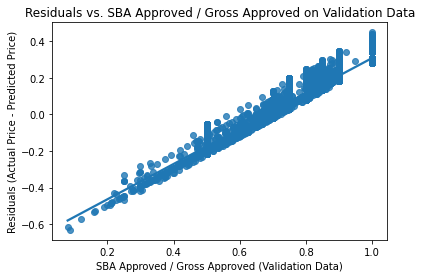

In [57]:
# Plotting residual Curves for the Regression model
residuals_3 = y_val - y_val_predicted_3
ax = sns.regplot(y_val, residuals_3)
ax.set_xlabel('SBA Approved / Gross Approved (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. SBA Approved / Gross Approved on Validation Data");

Cross Validation:

In [58]:
from sklearn.model_selection import KFold
from sklearn.base import clone
def cross_validate_rmse(model, X, y):
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    # Iterature thought cv-folds
    for train_index, val_index in five_fold.split(X):
        cv_X_train = X.iloc[train_index]
        cv_y_train = y.iloc[train_index]
        cv_X_val = X.iloc[val_index]
        cv_y_val = y.iloc[val_index]
        # Fit model
        model.fit(cv_X_train,cv_y_train)
        cv_y_predicted = model.predict(cv_X_val)
        cv_rmse = rmse(cv_y_val, cv_y_predicted)
        # Append RMSE scores
        rmse_values.append(cv_rmse)
    return rmse_values

In [59]:
cv_scores = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=X_train_sf, y=y_train)

In [60]:
# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: {}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: {}'.format(np.std(cv_scores)))

Cross-validation RMSE scores: [0.17183672752791557, 0.1714777864062617, 0.1715463537483894, 0.1712986719369886, 0.17141421381677993]
Cross-validation RMSE scores mean: 0.17151475068726701
Cross-validation RMSE scores std: 0.00018046156715809607


There is no effect of Cross-Validation

In [61]:
### Test data
y_test_predicted = model_3.predict(X_test_sf)
# Linear Regression - RMSE for training and validation data
rmse_test = rmse(y_test, y_test_predicted)
r2_test = r2_score(y_test, y_test_predicted)
print("For the linear regression model in part 3:\n", "RMSE for test data is: ",rmse_test,"\n","R2 Score for test data is: ",r2_test)

For the linear regression model in part 3:
 RMSE for test data is:  0.18813930607161958 
 R2 Score for test data is:  0.031110212931341863


**Numerical Feature Selection:**

In [62]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [63]:
# feature selection
def select_features(X_train, y_train, X_val, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_regression, k=15)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform val input data
	X_val_fs = fs.transform(X_val)
  # transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_val_fs, X_test_fs, fs

In [64]:
X_train_fs, X_val_fs, X_test_fs, fs = select_features(X_train, y_train, X_val, X_test)

In [65]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.555570
Feature 1: 0.413619
Feature 2: 0.413422
Feature 3: 0.411288
Feature 4: 0.410926
Feature 5: 0.410502
Feature 6: 0.409164
Feature 7: 0.404226
Feature 8: 0.409581
Feature 9: 0.407417
Feature 10: 0.002914
Feature 11: 0.001275
Feature 12: 0.001138
Feature 13: 0.006306
Feature 14: 0.000000
Feature 15: 0.000000
Feature 16: 0.000000
Feature 17: 0.000000
Feature 18: 0.002830
Feature 19: 0.000967
Feature 20: 0.001717
Feature 21: 0.003249
Feature 22: 0.000170
Feature 23: 0.000000
Feature 24: 0.001570
Feature 25: 0.001677
Feature 26: 0.000000
Feature 27: 0.001905
Feature 28: 0.003054
Feature 29: 0.000418
Feature 30: 0.000291
Feature 31: 0.001247
Feature 32: 0.001229
Feature 33: 0.000000
Feature 34: 0.002682
Feature 35: 0.003151
Feature 36: 0.001387
Feature 37: 0.000000
Feature 38: 0.000000
Feature 39: 0.003541
Feature 40: 0.002342
Feature 41: 0.000520
Feature 42: 0.001432
Feature 43: 0.008094
Feature 44: 0.000091
Feature 45: 0.002846
Feature 46: 0.001941
Feature 47: 0.004492
Fe

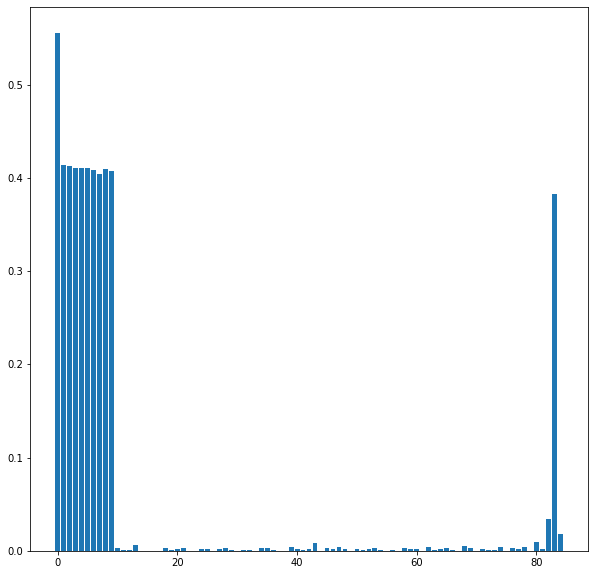

In [66]:
# plot the scores
plt.figure(figsize=(10,10))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [67]:
# Linear Regression - Performing Linear Regression
model_3 = LinearRegression(fit_intercept=True).fit(X_train_fs, y_train)
y_train_predicted_3 = model_3.predict(X_train_fs)
y_val_predicted_3 = model_3.predict(X_val_fs)
# Linear Regression - RMSE for training and validation data
rmse_train_3 = rmse(y_train, y_train_predicted_3)
rmse_val_3 = rmse(y_val, y_val_predicted_3)
r2_train_3 = r2_score(y_train, y_train_predicted_3)
r2_val_3 = r2_score(y_val, y_val_predicted_3)
print("For the linear regression model in part 3:\n", "RMSE for training data is: ",rmse_train_3,"\n","RMSE for validation data is: ",rmse_val_3,"\n","R2 Score for training data is: ",r2_train_3,"\n","R2 Score for validation data is: ",r2_val_3)

For the linear regression model in part 3:
 RMSE for training data is:  0.14559366288529965 
 RMSE for validation data is:  0.14592653576659212 
 R2 Score for training data is:  0.3045953700560168 
 R2 Score for validation data is:  0.30146974313653374


In [68]:
### Test data
y_test_predicted = model_3.predict(X_test_fs)
# Linear Regression - RMSE for training and validation data
rmse_test = rmse(y_test, y_test_predicted)
r2_test = r2_score(y_test, y_test_predicted)
print("For the linear regression model in part 3:\n", "RMSE for test data is: ",rmse_test,"\n","R2 Score for test data is: ",r2_test)

For the linear regression model in part 3:
 RMSE for test data is:  0.19912424961946432 
 R2 Score for test data is:  -0.08533449621372813


In [69]:
# Adding Annual Inflation Rate, Unemployment and State Income to our dataset

In [70]:
inflation_df = pd.read_csv('annual_inflation_clean.csv', low_memory=False)
# inflation_df = NAICS_BDS.drop([0])
inflation_df.head()

,inflation,year
0,1.457976,1960
1,1.070724,1961
2,1.198773,1962
3,1.239669,1963
4,1.278912,1964


In [71]:
income_df = pd.read_csv('state_income_clean.csv', low_memory=False)
# inflation_df = NAICS_BDS.drop([0])
income_df.head()

,ApprovalFY,Average_State_Income,State
0,2018,49936,AL
1,2017,51113,AL
2,2016,47221,AL
3,2015,44509,AL
4,2014,42278,AL


In [73]:
unemployment_df = pd.read_csv('Unemployment.csv')
#print(unemployment_df.info())
#print(unemployment_df.head())
unemployment_df['YEAR'] = unemployment_df['DATE'].astype(str).str[0:4]
Annual_unemployment_rate = unemployment_df.groupby('YEAR').agg({'UNRATE': ['mean']})['UNRATE'].reset_index() #Aggregate into annual unemployment data
Annual_unemployment_rate['YEAR'] = Annual_unemployment_rate['YEAR'].astype(int)
Annual_unemployment_rate

,YEAR,mean
0,1948,3.750000
1,1949,6.050000
2,1950,5.208333
3,1951,3.283333
4,1952,3.025000
...,...,...
70,2018,3.891667
71,2019,3.675000
72,2020,8.091667
73,2021,5.358333


In [74]:
inflation_df = inflation_df.rename(columns={"year": "YEAR"})
income_df = income_df.rename(columns={"ApprovalFY": "YEAR"})

In [75]:
df_merged = pd.merge(df_merged_NAICS_SBALoan, inflation_df,  how='left', left_on=['YEAR'], right_on = ['YEAR'])
df_merged = pd.merge(df_merged, income_df,  how='left', left_on=['State', 'YEAR'], right_on = ['State', 'YEAR'])
df_merged = pd.merge(df_merged, Annual_unemployment_rate,  how='left', left_on=['YEAR'], right_on = ['YEAR'])
df_merged = df_merged.dropna()
df_merged

,State,NAICS,YEAR,NewExist,MIS_Status,SBA_Appv,GrAppv,FIRM,DENOM,ESTABS_ENTRY,ESTABS_EXIT,JOB_CREATION,JOB_DESTRUCTION,REALLOCATION_RATE,FIRMDEATH_ESTABS,FIRMDEATH_EMP,inflation,Average_State_Income,mean
0,IN,45,1997,2.0,P I F,48000.0,60000.0,670945.0,13763872.0,110091.0,115364.0,2361731.0,2038489.0,29.621,73384.0,349798.0,2.33769,38889.0,4.941667
1,IN,72,1997,2.0,P I F,32000.0,40000.0,357519.0,9152783.0,69257.0,63282.0,1894562.0,1728105.0,37.761,45776.0,441164.0,2.33769,38889.0,4.941667
2,IN,62,1997,1.0,P I F,215250.0,287000.0,481657.0,12684590.0,60737.0,50485.0,1943403.0,1632957.0,25.747,35763.0,328510.0,2.33769,38889.0,4.941667
3,CT,33,1997,1.0,P I F,387750.0,517000.0,292577.0,16284152.0,28296.0,29516.0,1835979.0,1672272.0,20.539,22142.0,255029.0,2.33769,43985.0,4.941667
4,FL,81,1997,2.0,P I F,36000.0,45000.0,599136.0,4864066.0,62099.0,58638.0,800963.0,694752.0,28.567,42290.0,156087.0,2.33769,32455.0,4.941667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696108,MD,33,1997,1.0,P I F,25000.0,50000.0,292577.0,16284152.0,28296.0,29516.0,1835979.0,1672272.0,20.539,22142.0,255029.0,2.33769,46685.0,4.941667
696109,CA,31,1997,1.0,P I F,150000.0,200000.0,292577.0,16284152.0,28296.0,29516.0,1835979.0,1672272.0,20.539,22142.0,255029.0,2.33769,39694.0,4.941667
696110,OH,45,1997,1.0,P I F,56000.0,70000.0,670945.0,13763872.0,110091.0,115364.0,2361731.0,2038489.0,29.621,73384.0,349798.0,2.33769,36134.0,4.941667
696111,OH,45,1997,1.0,P I F,42500.0,85000.0,670945.0,13763872.0,110091.0,115364.0,2361731.0,2038489.0,29.621,73384.0,349798.0,2.33769,36134.0,4.941667


In [95]:
### Splitting the data into Train, Val and Test as per time-series:
df_merged_train_val = df_merged[df_merged['YEAR']<=2009]
df_merged_test = df_merged[df_merged['YEAR'] >= 2010]
y_train_val = df_merged_train_val['SBA_Appv'] / df_merged_train_val['GrAppv']
X_train_val = df_merged_train_val.drop(['SBA_Appv'], axis=1)
y_test = df_merged_test['SBA_Appv'] / df_merged_test['GrAppv']
X_test = df_merged_test.drop(['SBA_Appv'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state= 0)

In [77]:
#['State_CT', 'State_MA', 'State_NY', 'State_RI', 'NAICS_23', 'NAICS_44', 'NAICS_45', 'NAICS_54', 'NAICS_72', 'NAICS_81']

In [96]:
from sklearn.preprocessing import StandardScaler

# Define numerical features to use for modelling
num_features = ['GrAppv', 'FIRM', 'DENOM', 'ESTABS_ENTRY', 'ESTABS_EXIT', 'JOB_CREATION', 'JOB_DESTRUCTION', 'REALLOCATION_RATE', 'FIRMDEATH_ESTABS', 'FIRMDEATH_EMP', 'inflation', 'Average_State_Income', 'mean']

# Define categorical features to use for modelling
cat_features = ['State', 'NAICS', 'MIS_Status']
misc_features = ['YEAR', 'NewExist']

# Fitting scaler for the training data
scaler = StandardScaler()
scaler.fit(X_train[num_features])

def features_scale_and_dummies(df):
    scaled = df[num_features].copy()
    # Convert numeric features to standard units
    scaled.iloc[:, :] = scaler.transform(scaled)
    # Convert categorical features using dummy encoding
    categoricals = [pd.get_dummies(df[s], prefix=s, drop_first=True) for s in cat_features]
    misc = df[misc_features]
    return pd.concat([scaled] + categoricals + [misc], axis=1)

In [97]:
X_train = features_scale_and_dummies(X_train)
X_val = features_scale_and_dummies(X_val)
X_test = features_scale_and_dummies(X_test)

In [98]:
X_train

,GrAppv,FIRM,DENOM,ESTABS_ENTRY,ESTABS_EXIT,JOB_CREATION,JOB_DESTRUCTION,REALLOCATION_RATE,FIRMDEATH_ESTABS,FIRMDEATH_EMP,...,NAICS_55,NAICS_56,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,MIS_Status_P I F,YEAR,NewExist
660147,-0.315042,0.756133,-0.972765,-0.025204,-0.178398,-1.069514,-1.174246,-0.298800,-0.005293,-0.850900,...,0,0,0,0,0,0,1,1,1996,1.0
280664,0.115217,-0.237355,-1.079449,0.101189,-0.194299,-0.691166,-1.040773,0.658121,0.002686,-0.573001,...,0,0,0,0,0,0,0,0,1989,2.0
265110,-0.614036,0.983161,-0.331270,0.670628,1.173460,-0.361418,0.091600,0.276011,1.137046,0.156937,...,0,0,0,0,0,0,0,0,2009,1.0
662206,-0.285872,0.110917,0.637680,-0.397909,-0.462418,0.118475,-0.010520,-1.066462,-0.319204,0.354712,...,0,0,0,1,0,0,0,1,1996,1.0
263886,-0.431723,-0.512595,0.086418,-0.320523,-0.192741,0.569374,0.284514,0.281397,-0.130360,1.070983,...,0,0,0,0,0,1,0,1,2000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388147,-0.103559,-0.899753,1.469153,-1.329068,-1.083863,0.156526,1.312869,-1.489865,-1.041888,0.243183,...,0,0,0,0,0,0,0,1,2001,1.0
152606,-0.481571,1.125405,-0.504415,1.584694,0.746261,0.525307,-0.316628,0.572093,0.963589,0.115241,...,0,0,0,0,0,0,0,1,2006,2.0
118151,-0.614036,1.176431,-0.440500,1.132568,1.155222,0.023437,0.334236,1.509565,1.446553,0.467329,...,0,0,0,0,0,0,0,1,2007,2.0
473154,-0.294076,0.225171,-1.060186,0.492655,0.425517,-0.469545,-0.421322,2.913827,0.592532,0.062293,...,0,0,0,0,0,0,0,1,1993,1.0


In [139]:
# features_considered = ['State_CT', 'State_MA', 'State_NY', 'State_RI', 'NAICS_23', 'NAICS_44', 'NAICS_45', 'NAICS_54', 'NAICS_72', 'NAICS_81','inflation', 'Average_State_Income', 'mean', 'GrAppv'] #'REALLOCATION_RATE', 'JOB_DESTRUCTION'

In [140]:
# X_train_inc_inf = X_train[features_considered]
# X_test_sf_inc_inf = X_test[features_considered]
# X_val_sf_inc_inf = X_val[features_considered]

In [145]:
# Linear Regression - Performing Linear Regression
from sklearn.linear_model import LinearRegression
model_3 = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_train_predicted_3 = model_3.predict(X_train)
y_val_predicted_3 = model_3.predict(X_val)
# Linear Regression - RMSE for training and validation data
rmse_train_3 = rmse(y_train, y_train_predicted_3)
rmse_val_3 = rmse(y_val, y_val_predicted_3)
r2_train_3 = r2_score(y_train, y_train_predicted_3)
r2_val_3 = r2_score(y_val, y_val_predicted_3)
print("For the linear regression model in part 3:\n", "RMSE for training data is: ",rmse_train_3,"\n","RMSE for validation data is: ",rmse_val_3,"\n","R2 Score for training data is: ",r2_train_3,"\n","R2 Score for validation data is: ",r2_val_3)

For the linear regression model in part 3:
 RMSE for training data is:  0.14108775883988764 
 RMSE for validation data is:  0.14122305091182386 
 R2 Score for training data is:  0.3469081262729562 
 R2 Score for validation data is:  0.3466639126174442


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


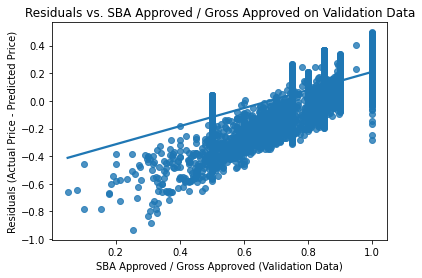

In [146]:
# Plotting residual Curves for the Regression model
residuals_3 = y_val - y_val_predicted_3
ax = sns.regplot(y_val, residuals_3)
ax.set_xlabel('SBA Approved / Gross Approved (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. SBA Approved / Gross Approved on Validation Data");

In [147]:
### Test data
y_test_predicted = model_3.predict(X_test)
# Linear Regression - RMSE for training and validation data
rmse_test = rmse(y_test, y_test_predicted)
r2_test = r2_score(y_test, y_test_predicted)
print("For the linear regression model in part 3:\n", "RMSE for test data is: ",rmse_test,"\n","R2 Score for test data is: ",r2_test)

For the linear regression model in part 3:
 RMSE for test data is:  0.17960393370375752 
 R2 Score for test data is:  0.11681179108117667


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


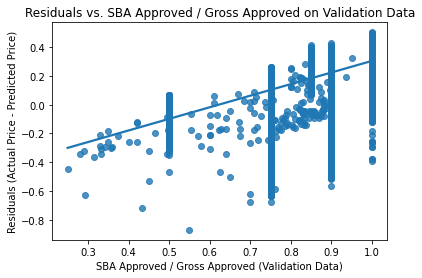

In [148]:
# Plotting residual Curves for the Regression model on test data
residuals_test = y_test - y_test_predicted
ax = sns.regplot(y_test, residuals_test)
ax.set_xlabel('SBA Approved / Gross Approved (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. SBA Approved / Gross Approved on Validation Data");

In [ ]:
####TRASH#####

In [ ]:
# ###Polynomial Regression
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures()
# poly.fit(X_train_2)
# X_train_2_poly = poly.transform(X_train_2)
# X_val_2_poly = poly.transform(X_val_2)

In [ ]:
# Linear Regression - Performing Linear Regression
# poly_model_2 = LinearRegression(fit_intercept=True).fit(X_val_2_poly, y_train)
# y_train_predicted_poly_2 = poly_model_2.predict(X_train_2_poly)
# y_val_predicted_poly_2 = poly_model_2.predict(X_val_2_poly)
# # Linear Regression - RMSE for training and validation data
# rmse_train_poly_2 = rmse(y_train, y_train_predicted_poly_2)
# rmse_val_poly_2 = rmse(y_val, y_val_predicted_poly_2)
# print("For the linear regression model in part 2:\n", "RMSE for training data is: ",rmse_train_poly_2,"\n","RMSE for validation data is: ",rmse_val_poly_2)

In [87]:
len(X_train.columns)

87

In [88]:
###PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=len(X_train.columns), random_state = 0)
pca.fit(X_train)

PCA(n_components=87, random_state=0)

In [89]:
from sklearn import preprocessing
# X_train_pca = pca.transform(preprocessing.scale(X_train))
X_train_pca = pca.transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca)
# X_val_pca = pca.transform(preprocessing.scale(X_val))
X_val_pca = pca.transform(X_val)
X_val_pca = pd.DataFrame(X_val_pca)

In [90]:
variance = pca.explained_variance_
prop_variance = pca.explained_variance_ratio_
cum_prop_variance = np.cumsum(pca.explained_variance_ratio_)
pca_summary = pd.DataFrame({'Variance':variance, 'Proportion of Variance':prop_variance, 'Cumulative Proportion':cum_prop_variance}).T
pca_column_name_array = []
for num in range(1,len(X_train.columns)+1):
    name='PC'+str(num)
    pca_column_name_array.append(name)
pca_summary.columns = pca_column_name_array

In [91]:
pca_summary

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87
Variance,22.735580,5.729601,2.009210,1.505539,1.037402,0.956915,0.521833,0.472245,0.211379,0.179821,...,0.002693,0.002616,0.001772,0.001641,0.001526,0.001072,0.000687,0.000354,0.000158,0.000039
Proportion of Variance,0.608905,0.153450,0.053811,0.040321,0.027784,0.025628,0.013976,0.012648,0.005661,0.004816,...,0.000072,0.000070,0.000047,0.000044,0.000041,0.000029,0.000018,0.000009,0.000004,0.000001
Cumulative Proportion,0.608905,0.762355,0.816166,0.856487,0.884271,0.909899,0.923875,0.936523,0.942184,0.947000,...,0.999736,0.999806,0.999853,0.999897,0.999938,0.999967,0.999985,0.999995,0.999999,1.000000


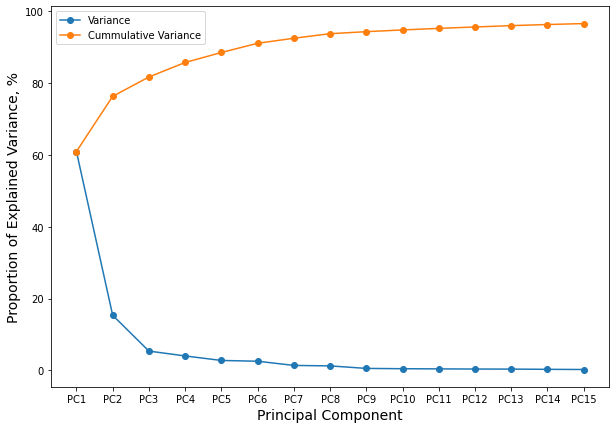

In [92]:
plt.figure(figsize=(10,7))
plt.plot(pca_summary.iloc[1:2].T.loc["PC1":"PC15"]*100, marker = 'o', linestyle= '-')
plt.plot(pca_summary.iloc[2:3].T.loc["PC1":"PC15"]*100, marker = 'o', linestyle= '-')
plt.legend(['Variance', 'Cummulative Variance'])
plt.xlabel('Principal Component', fontsize = 14)
plt.ylabel('Proportion of Explained Variance, %', fontsize = 14);

In [93]:
# Linear Regression - Performing Linear Regression
model_4 = LinearRegression().fit(X_train_pca.iloc[: , :10], y_train)
y_train_predicted_4 = model_4.predict(X_train_pca.iloc[: , :10])
y_val_predicted_4 = model_4.predict(X_val_pca.iloc[: , :10])
# Linear Regression - RMSE for training and validation data
rmse_train_4 = rmse(y_train, y_train_predicted_4)
rmse_val_4 = rmse(y_val, y_val_predicted_4)
r2_train_4 = r2_score(y_train, y_train_predicted_4)
r2_val_4 = r2_score(y_val, y_val_predicted_4)
print("For the linear regression model in part 4:\n", "RMSE for training data is: ",rmse_train_4,"\n","RMSE for validation data is: ",rmse_val_4,"\n","R2 Score for training data is: ",r2_train_4,"\n","R2 Score for validation data is: ",r2_val_4)

For the linear regression model in part 4:
 RMSE for training data is:  0.14519674702080057 
 RMSE for validation data is:  0.14528851301206094 
 R2 Score for training data is:  0.30831336611528726 
 R2 Score for validation data is:  0.3085066210753352


In [94]:
### Test data
X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca)
y_test_predicted = model_4.predict(X_test.iloc[: , :10])
# Linear Regression - RMSE for training and validation data
rmse_test = rmse(y_test, y_test_predicted)
r2_test = r2_score(y_test, y_test_predicted)
print("For the linear regression model in part 3:\n", "RMSE for test data is: ",rmse_test,"\n","R2 Score for test data is: ",r2_test)

For the linear regression model in part 3:
 RMSE for test data is:  0.22480614357125192 
 R2 Score for test data is:  -0.38368720405548307


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
